In [1]:
include("speciale_tools.jl")
import JLD
import PyPlot

In [2]:
data_folder = "/Users/simon/Documents/DTU fag/Speciale/houston_new"
VV_files,VH_files,coherence_VV_files,coherence_VH_files = _sort_prossed_files(data_folder);

In [3]:
VV = _load_jld(VV_files[[1,3]],data_folder);
VH = _load_jld(VH_files[[1,3]],data_folder);

## VV

In [4]:
co = VV[1][:,end:-1:1]
pre = VV[2][:,end:-1:1];

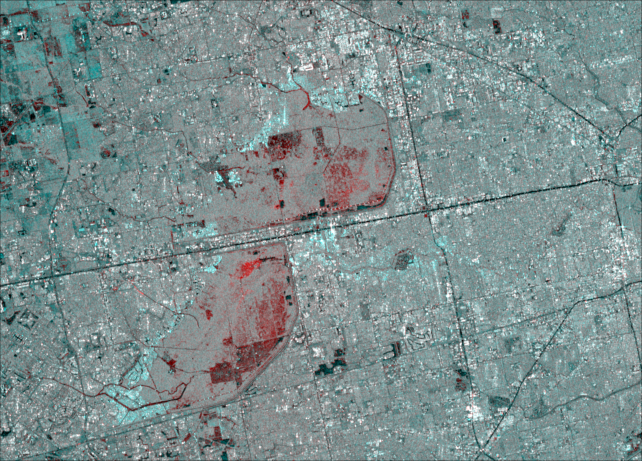

In [5]:
imgVV = pretty_img([co,pre],min_vv,max_vv)

In [6]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [7]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


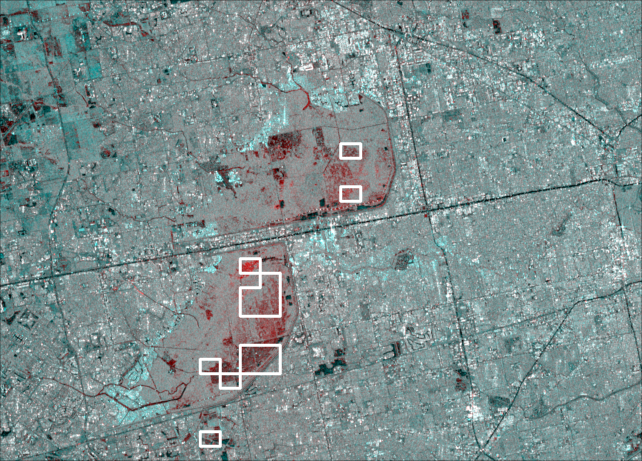

In [8]:
subset_edges = get_edges(bm_mask);
add_mask(imgVV,subset_edges,(1,1,1))

In [9]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed
t_0 = [y_seed+1, -1]

2-element Array{Float64,1}:
 -12.45
  -1.0 

In [13]:
f_test(x1,x2) = sse_water_fit(flood_band,change_band,seed_mask,bm_mask
    , p_fit[[1,3,5]],w_sum,edges,y, [x1,x2])


f_test (generic function with 1 method)

In [17]:
function grad_eval(f,x,delta)
    dfdx = similar(x)
    f_0 = f(x...)
    for i in 1:length(x)
        xp = copy(x)
        xb = copy(x)
        xp[i] += delta
        xb[i] -= delta
        dfdx[i] = (f(xp...)-f(xb...))/(2*delta)
    end
    return dfdx, f_0
end

grad_eval (generic function with 1 method)

In [37]:
t_0

2-element Array{Float64,1}:
 -12.45
  -1.0 

In [ ]:

dfdx_tol = 10^-8
df_tol = 10^-7
no_step_max =3
iter_max = 4


In [21]:

function grad_decent(f, x_0 ; no_step_max =3, iter_max = 50,df_tol = 10^-8 ,dfdx_tol = 10^-8)

    step_size = 10.0 .^(0:4)
    delta = 10^-4

    x_i = x_0
    no_step_count = 0
    iter_count = 0


    #test if better or the first
    while (no_step_count<no_step_max)
        iter_count += 1;
        dfdx, f_i =  grad_eval(f,x_i,delta)

        if transpose(dfdx)*dfdx > dfdx_tol
            x_old = x_i
            
            #check different steps sizes and choo the best
            f_steps = [f( (x_i .- dfdx.*elem)...) for elem in step_size]
            min_idx = argmin(f_steps)
            
            # Chec decrease in loose function
            df = f_i - f_steps[min_idx];
            
            if df < df_tol
                #decreasing  delta becuse no imporvment found in the direction of the gradiant
                delta *= 0.1
                no_step_count += 1
            else
                # update x_i with optima step and reset no_step_count
                x_i = x_i.- dfdx.* step_size[min_idx]
                no_step_count = 0
            end
        else
            #incresing delta becuse no gradient found
            delta *= 10
            no_step_count += 1
        end   

        if (iter_count > iter_max)
            println("MAX NUMBER OF ITERATIONS REACHED")
            break
        end

    end

    return x_i, iter_count

end
    

grad_decent (generic function with 1 method)

In [22]:
rg_thresholds, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0)

([-7.46153, -1.9849], 9)

In [20]:
sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, rg_thresholds)*10^4

1.1113937928419808

In [99]:
x_i

2-element Array{Float64,1}:
 -9.18212658099574 
 -1.999933419319462

In [86]:
sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, x_i)*10^4

1.1385384746426146

In [87]:
# optimize y_RG and delta_sigma tresholds

res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
rg_thresholds = res.minimizer

In [90]:
sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, rg_thresholds)*10^4

1.1096120815747708

In [23]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [24]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

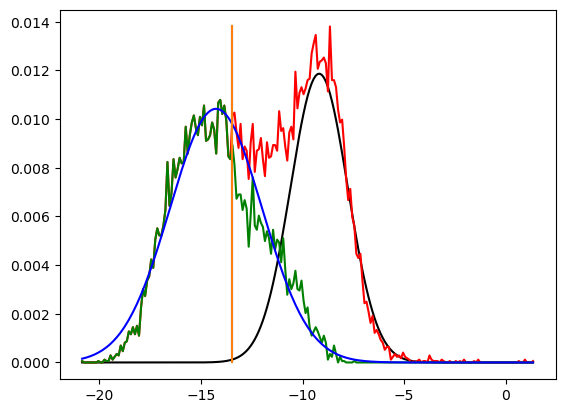

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14173a6a0>

In [25]:

PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
#PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))

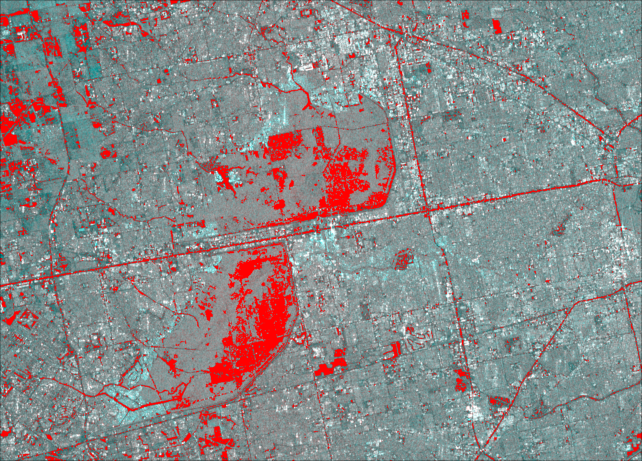

In [26]:
add_mask(imgVV,flood_mask,(1,0,0))

In [27]:
rg_thresholds

2-element Array{Float64,1}:
 -7.4615265050274475
 -1.984899861261476 

In [28]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

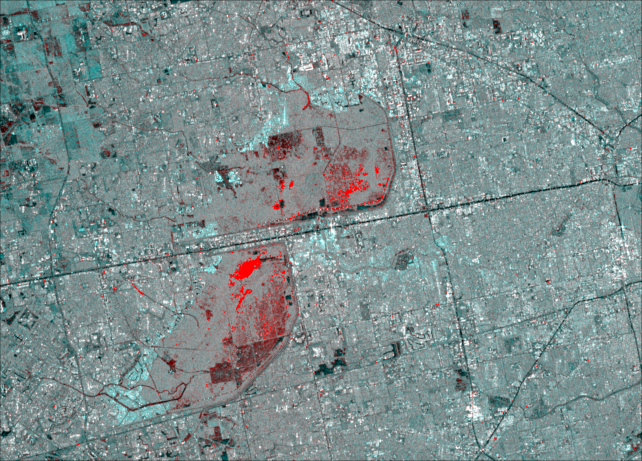

In [29]:
add_mask(imgVV,final_mask,(1,0,0))

## VH

In [73]:
co = VH[1][:,end:-1:1]
pre = VH[2][:,end:-1:1];

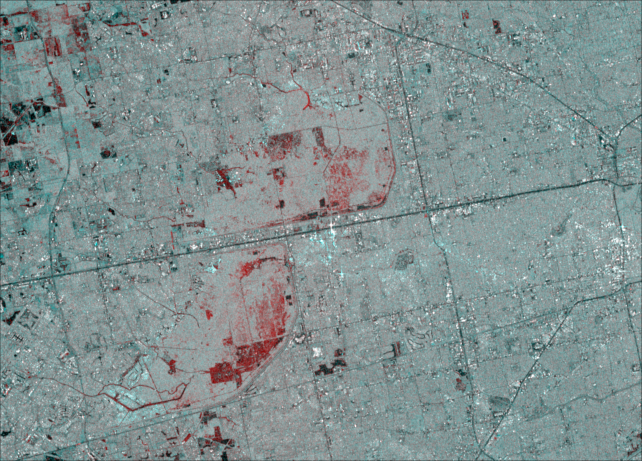

In [74]:
imgVH = pretty_img([co,pre],min_vh,max_vh)

In [75]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [76]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


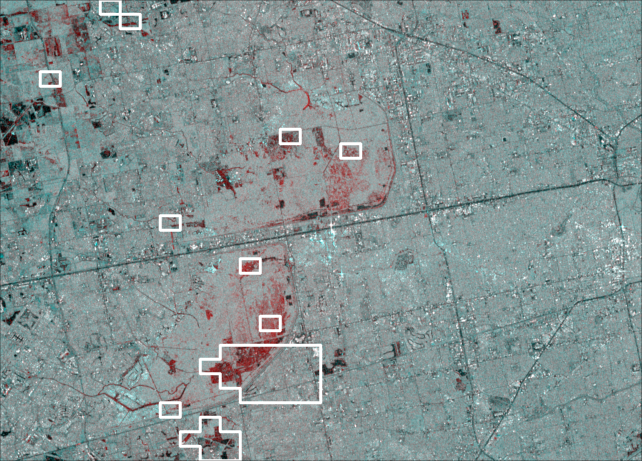

In [77]:
subset_edges = get_edges(bm_mask);
add_mask(imgVH,subset_edges,(1,1,1))

In [78]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed

# optimize y_RG and delta_sigma tresholds
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward)

# use optimize values to find flood mask
rg_thresholds = res.minimizer
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [79]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

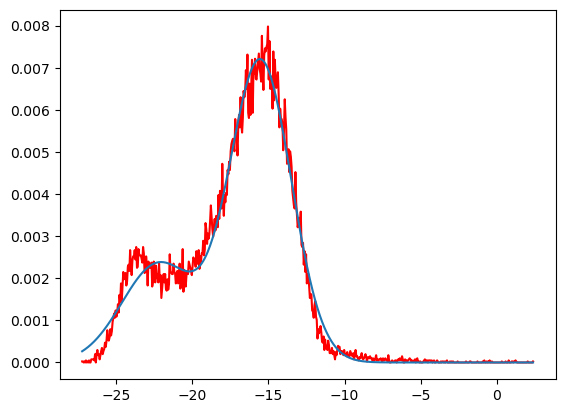

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14638e4a8>

In [80]:
PyPlot.figure()
PyPlot.plot(y,w,color="r")
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )


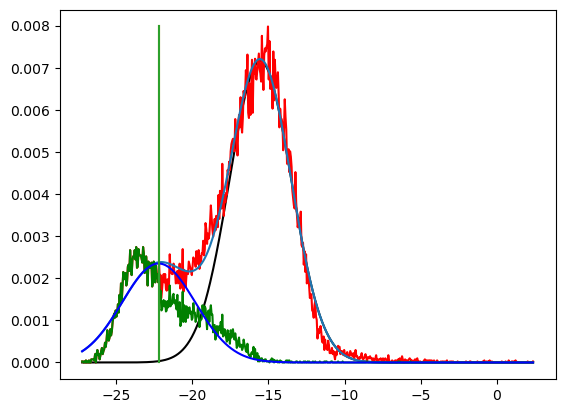

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14668ac88>

In [81]:

PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))

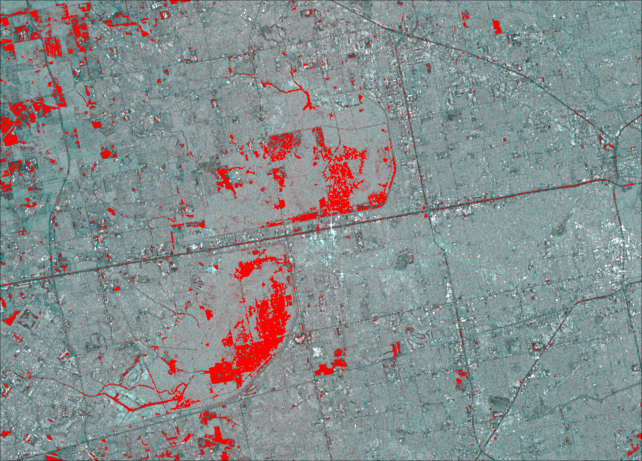

In [82]:
add_mask(imgVH,flood_mask,(1,0,0))

In [83]:
rg_thresholds

2-element Array{Float64,1}:
 33.61796875 
 -2.298828125

In [84]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

In [85]:
sum(reshape(final_mask,:))

0

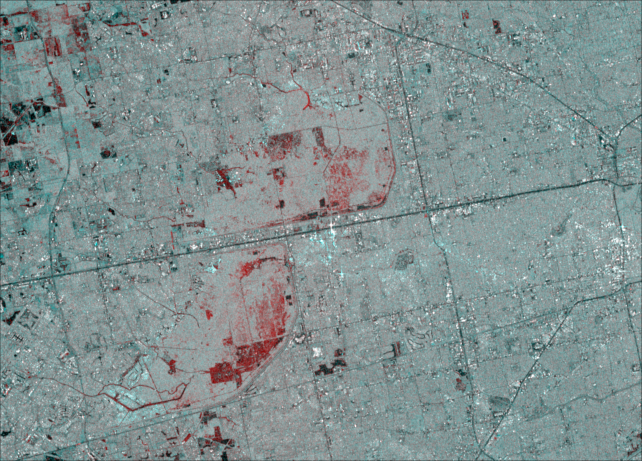

In [86]:
add_mask(imgVH,final_mask,(1,0,0))